# Economics Problem Set 3

We adapt the code from the notebooks:

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import time

# to print plots inline
%matplotlib inline

## 1. Overview of the Theory
The firm's optimization problem can be written as:

$$ V(z,k) = max_{k'} \pi(z,k) - p^{k}(k'-(1-\delta)k) - c(k',k) + \beta V(z',k') $$

This time around, we are NOT going to assume that $z$ is deterministic and stationary.

Instead, z follows the AR(1) process given by:

$$ ln(z_{t+1}) = \rho ln(z_{t}) + (1-\rho)\mu + \varepsilon_{t}, $$

where $\varepsilon_{t}\sim N(0,\sigma_{\varepsilon})$.  


### 2.1 Parameterization
To solve a numerical problem, we need to set values to the parameters.  We also need to specify the adjustment cost function.  Adjustment costs will be assumed to be quadratic:

$$ c(k',k) = \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

Operating profits are given by $zk^{alpha_{k}}l^{\alpha_{l}} - wl$.  After solving the firm's intra-temporal problem for the optimal choice of $l$ given $k4$, we find

$$ \pi(z,k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} z^{\frac{1}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

Or, noting that $z=1$ in the deterministic model we're studying here:

$$ \pi(k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

We then choose the following parameterization:

| Paramter | Description   | Value|
|------|------||------|
    | $\alpha_{k}$ | Capital's share of output | 0.297 |
   | $\alpha_{l}$ | Labor's share of output | 0.650 |
   | $\delta$ | Depreciation rate | 0.154 |
   | $\psi$ | Coefficient on quadratic adjustment costs | 1.080 |
   | $w$   | Wage rate | 0.700 |
   | $r$   | Interest rate | 0.040 |
   | $\sigma_z$   | Std deviation of disturbances to z | 0.213 |
   | $\mu$   | Mean of ln(z) process | 0 |
   | $\rho$   | Persistence of z process | 0.7605 |
   | $sizez$   | Number of grid points in z space | 9 |




In [2]:
# specify parameters
alpha_k = 0.297
alpha_l = 0.65
delta = 0.154
psi = 1.08
w = 0.7
r= 0.04
sigma_z = 0.213
mu = 0
rho = 0.7605
sizez = 9

betafirm = 1/(1+r)

### 2.2 Discretizing the state space for capital

To solve this problem we will be evaluating the value function over a discrete grid of points in the state space.  Our state space are the possible values of the firm's capital stock.  We need to put some thought into how to choose these grid points, since we are approximating the continuous value function over this grid.  

As a starting point, recall the solution to the firm's problem without adjustment costs:

$$ k_{t+1} = \left[\left(\frac{\alpha_{k}}{\bar{r}  + \delta}\right)^{1-\alpha_{l}}\left(\frac{\alpha_{l}}{w}\right)^{\alpha_{l}}z_{t+1}^{\alpha_{l}}\right]^{1-\alpha_{k}-\alpha_{l}} $$

This value for $k'$ in the model with no adjustment costs is a good place to center the grid as it's close to the steady-state value of the problem with adjustment costs.  In the steady-state, the firm's capital stock does not change and thus with the adjustment cost function specified, only small costs are paid as investment is just enough to offset depreciation.

Next, we need to think about how to space the grid points.  One consideration here is that since we are approximating a value function that is concave, we want to have more grid points in the space where there is more curvature in the function.  That is, we want more grid points on the part of the grid with smaller amounts of capital as the value function will have more curvature in this range since it's a concave function.  Second, there is some convenience in spacing the grid points out so that we know the number of points between the points for $k$ and $(1-\delta)k$ (this will be more apparent when we get to models with other types of adjustment costs).

Given these two considerations, let us define `dens` as the number of grid points between $k$ and $(1-\delta)k$ and then define the sequence of grid points by

$$ k^{i} = (1-\delta)^{\frac{1}{\texttt{dens}}}k^{i+1} $$

We implement this in the code below, setting the lower bound of the capital grid to a small, positive number, the upper bound to a multiple of the $k'$ implied by Equation (2), and then determining the number of grid points between these bounds given our rule for spacing described above.

Note: since the mean of ln(z) is 0, the mean of z is $e^0 = 1$, so we still use a similar grid space for k. However, since the exponential obviously grows very quickly, I increase the upper bound of the grid to $3*kbar$.

In [121]:
z = 1
dens = 2

sigma_eps = 0.213
sigma_z = 0.213 / ((1 - rho ** 2) ** (1 / 2))

# put in bounds here for the capital stock space
kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
                                         (alpha_l / (1 - alpha_l)))) /
         (alpha_k * (z ** (1 / (1 - alpha_l))))) **
         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2.5*kstar
lb_k = 0.001
ub_k = kbar
print(kbar)
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
kvec = K[::-1]
sizek = kvec.shape[0]

del z
print(sizek)

16.773406959191867
118


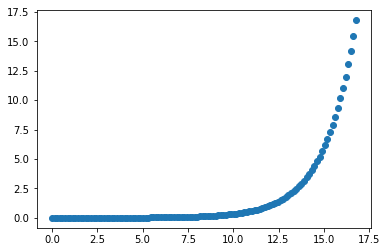

In [122]:
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, kvec)

We move on to the z-space grid:

##  Adda-Cooper (2003) method

Let us illustrate the general approach of these approximation methods through the Adda and Cooper (2003, pp. 56-59) (henceforth AC) method.  

AC start by dividing the real line into intervals.  In particular, they divide the real line into intervals such that $z_{t}$ has an equal probability of falling into any of the intervals.  Since $\varepsilon$ is distributed normally, the cut-off points given by $\left\{z^{i}\right\}_{i=0}^{N}$ for these intervals are defined by:

$$ \Phi\left(\frac{z^{i+1}-\mu}{\sigma_{z}}\right) - \Phi\left(\frac{z^{i}-\mu}{\sigma_{z}}\right) = \frac{1}{N}, $$

where $N$ are the number of grid points in our discretized grid space and $\Phi(\cdot)$ is the cumulative density function of the standard normal distribution.  Solving this recursively we find that each cut-off point is given by:

$$ z^{i} = \sigma_{z} \Phi^{-1}\left(\frac{i-1}{N}\right) + \mu $$ 


In [123]:
# import packages
from scipy.stats import norm


# sigma_z = abs(ln(0.213))

# Compute cut-off values
N = sizez  # number of grid points (will have one more cut-off point than this)
z_cutoffs = (sigma_z * norm.ppf(np.arange(N + 1) / N)) + mu
print('Cut-off values = ', z_cutoffs)


Cut-off values =  [       -inf -0.40040229 -0.25084498 -0.14128994 -0.04582867  0.04582867
  0.14128994  0.25084498  0.40040229         inf]


Now that we've defined the intervals through these cut-off values, we'll next want to compute the average value of $z$ in each of these intervals.  These values will be our grid points.  Let $z_{p}^{i}$ be grid point $i$ and define $z_{p}^{i}$ as the mean value of $z_{t}$ conditional on $z_{t}\in\left[z^{i},z^{i+1}\right]$.  That is:

$$ z_{p}^{i} = E\left(z_{t}|z_{t}\in \left[z^{i},z^{i+1}\right] \right) = \sigma_{z} \frac{\phi((z^{i}-\mu)/\sigma_z) - \phi((z^{i+1}-\mu)/\sigma_z)}{\Phi((z^{i+1}-\mu)/\sigma_z) - \Phi((z^{i}-\mu)/\sigma_z)} + \mu $$

Simplifying:

$$ z_{p}^{i} = N \sigma_z \left(\phi\left(\frac{z^{i}-\mu}{\sigma_z}\right) - \phi\left(\frac{z^{i+1}-\mu}{\sigma_z}\right) \right) + \mu $$

In [124]:
# import packages
import scipy.integrate as integrate

# define function that we will integrate
def integrand(x, sigma_z, sigma_eps, rho, mu, z_j, z_jp1):
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
            * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma_eps)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma_eps)))
    
    return val

# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args = (sigma_z, sigma_eps, rho, mu,
                                         z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i,j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]
        
# print('Transition matrix = ', pi)
# print('pi sums = ', pi.sum(axis=0), pi.sum(axis=1))
pi
'''for i in range(pi.shape[0]):
    print("Region"+ str(i))
    print(sum(pi[:5,i]))
    print(sum(pi[4:,i]))'''

'for i in range(pi.shape[0]):\n    print("Region"+ str(i))\n    print(sum(pi[:5,i]))\n    print(sum(pi[4:,i]))'

In [125]:
# compute grid points for z
lnz_grid = ((N * sigma_z * (norm.pdf((z_cutoffs[:-1] - mu) / sigma_z)
                              - norm.pdf((z_cutoffs[1:] - mu) / sigma_z)))
              + mu)
print('Grid points = ', lnz_grid)

Grid points =  [-0.55913938 -0.32004072 -0.19425291 -0.09290094  0.          0.09290094
  0.19425291  0.32004072  0.55913938]


In [126]:
# Retrieve the actual z grid values (until now we looked only at ln(z))
z_grid = np.exp(lnz_grid)
z_grid

array([ 0.57170087,  0.72611947,  0.82344962,  0.91128377,  1.        ,
        1.09735302,  1.21440337,  1.37718384,  1.74916648])

In [127]:
'''import numpy as np
import scipy.stats as st
from scipy.stats import norm
import scipy.integrate as integrate

def integrand(x, sigma_z, sigma, rho, mu, z_j, z_jp1):
    """
    Integrand in the determination of transition probabilities from the Adda-
    Cooper method.
    """
    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))
           * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma)
               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma)))

    return val


# compute transition probabilities
pi = np.empty((N, N))
for i in range(N):
    for j in range(N):
        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],
                                 args=(sigma_z, sigma, rho, mu,
                                       z_cutoffs[j], z_cutoffs[j + 1]))
        pi[i, j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]

'''

'import numpy as np\nimport scipy.stats as st\nfrom scipy.stats import norm\nimport scipy.integrate as integrate\n\ndef integrand(x, sigma_z, sigma, rho, mu, z_j, z_jp1):\n    """\n    Integrand in the determination of transition probabilities from the Adda-\n    Cooper method.\n    """\n    val = (np.exp((-1 * ((x - mu) ** 2)) / (2 * (sigma_z ** 2)))\n           * (norm.cdf((z_jp1 - (mu * (1 - rho)) - (rho * x)) / sigma)\n               - norm.cdf((z_j - (mu * (1 - rho)) - (rho * x)) / sigma)))\n\n    return val\n\n\n# compute transition probabilities\npi = np.empty((N, N))\nfor i in range(N):\n    for j in range(N):\n        results = integrate.quad(integrand, z_cutoffs[i], z_cutoffs[i + 1],\n                                 args=(sigma_z, sigma, rho, mu,\n                                       z_cutoffs[j], z_cutoffs[j + 1]))\n        pi[i, j] = (N / np.sqrt(2 * np.pi * sigma_z ** 2)) * results[0]\n\n'

We can now establish the profit and cash-flow functions as grids, recall:

$$ \pi(z,k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} z^{\frac{1}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

Per period flows are then:

$$ e(k,k',z) = \pi(k, z) - (k'-(1-\delta)k) - \frac{\psi}{2}\left(\frac{k'-(1-\delta)k}{k}\right)^{2}k $$

In [246]:
# operating profits, op

op = np.zeros((sizek, sizez))

for i in range(sizez):
    op[:, i] = (1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * (z_grid[i] ** (1 / (1 - alpha_l))) * (kvec ** (alpha_k / (1 - alpha_l)))
    

# firm cash flow, e
e = np.zeros((sizek, sizek, sizez))
for z in range(sizez):
    for i in range(sizek):
        for j in range(sizek):
                e[ i, j, z] = (op[i,z] - kvec[j] + ((1 - delta) * kvec[i]) -
                           ((psi / 2) * ((kvec[j] - ((1 - delta) * kvec[i])) ** 2)
                            / kvec[i]))

In [129]:
op[-5:,:5]

array([[ 0.5086382 ,  1.00714612,  1.44269727,  1.92724498,  2.51311436],
       [ 0.54604029,  1.08120539,  1.54878426,  2.06896261,  2.69791318],
       [ 0.5861927 ,  1.16071052,  1.66267223,  2.22110126,  2.89630095],
       [ 0.62929767,  1.24606196,  1.78493482,  2.38442725,  3.10927693],
       [ 0.67557231,  1.33768961,  1.91618784,  2.55976321,  3.33791384]])

In [130]:
e[-4:,:4, 0]

array([[ 6.54352373,  6.5435166 ,  6.54350885,  6.54350042],
       [ 7.10674451,  7.10673739,  7.10672964,  7.10672122],
       [ 7.71853646,  7.71852934,  7.71852159,  7.71851316],
       [ 8.38309524,  8.38308811,  8.38308036,  8.38307194]])

## 3. Value Function Iteration

Beyond adjusting some dimensions (adding z), the stochastic VFI works differently, since it takes into account all possible states of shock through the expectation operator:

$$ V_{i+1}(k, z) = max_{k'} \pi(k, z) - (k'-(1-\delta)k) - c(k',k) + \beta \mathbb{E}[V_{i}(k', z')] $$

where

$$ \mathbb{E}[V_{i}(k', z')] = \sum_{z'} P_{z|z'} V_{i}(k', z')$$


In [250]:
VFtol = 1e-4
#VFdist = 7.0
VFmaxiter = 300
#V = np.zeros((sizek, sizez))  # initial guess at value function
V = np.ones((sizek, sizez))
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
# Vstore = np.zeros((sizek, VFmaxiter, sizez))  # initialize Vstore array
#VFiter = 1
#start_time = time.clock()

In [251]:
VFdist = 7.0
VFiter = 1
start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for h in range(sizez): 
                Vmat[i, j, h] = e[i, j, h] + betafirm \
                * V[j,:].dot(pi[:,h])
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')


VF = V


Value function converged after this many iterations: 251
VFI took  60.63923399999999  seconds to solve


In [252]:
PF1 = np.copy(PF)

### Value Function


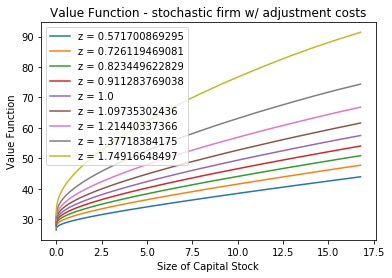

In [133]:
for z in range(sizez):
    plt.plot(kvec, V[:,z], label ='z = '+str(z_grid[z]))
plt.legend()
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - stochastic firm w/ adjustment costs')

### Policy functions

In [253]:
optK = kvec[PF]
optI = np.zeros((sizek, sizez))
for i in range(sizez):
    optI[:,i] = optK[:,i] - (1 - delta) * kvec
    
    
optK1 = np.copy(optK)
optI1 = np.copy(optI)

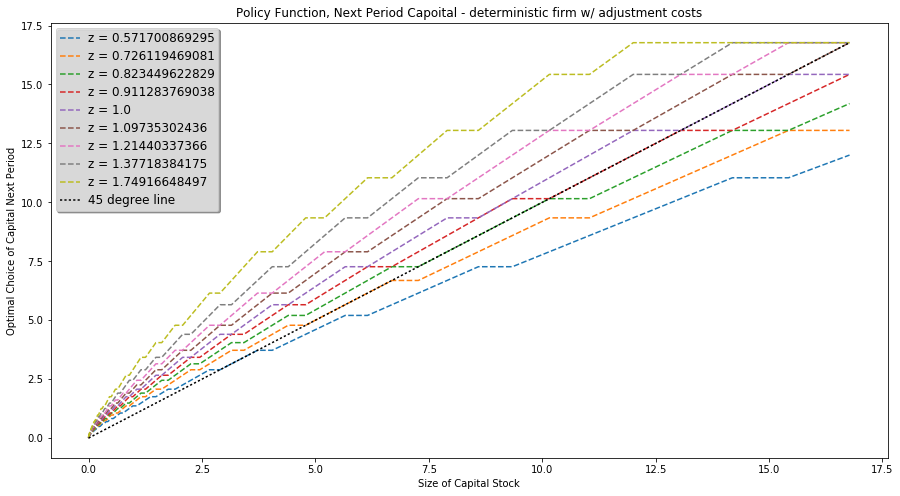

In [135]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,8))
for z in range(sizez):
    ax.plot(kvec, optK[:,z], '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

### Investment Rule

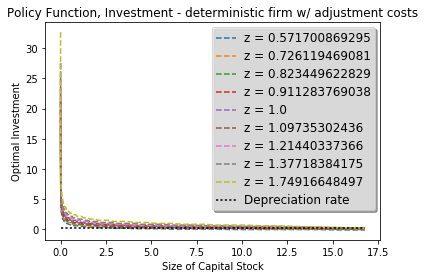

In [136]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots()
for z in range(sizez):
    ax.plot(kvec, (optI[:,z]/kvec), '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')

Barely visible, so we reduce the extent of the y-axis shown:

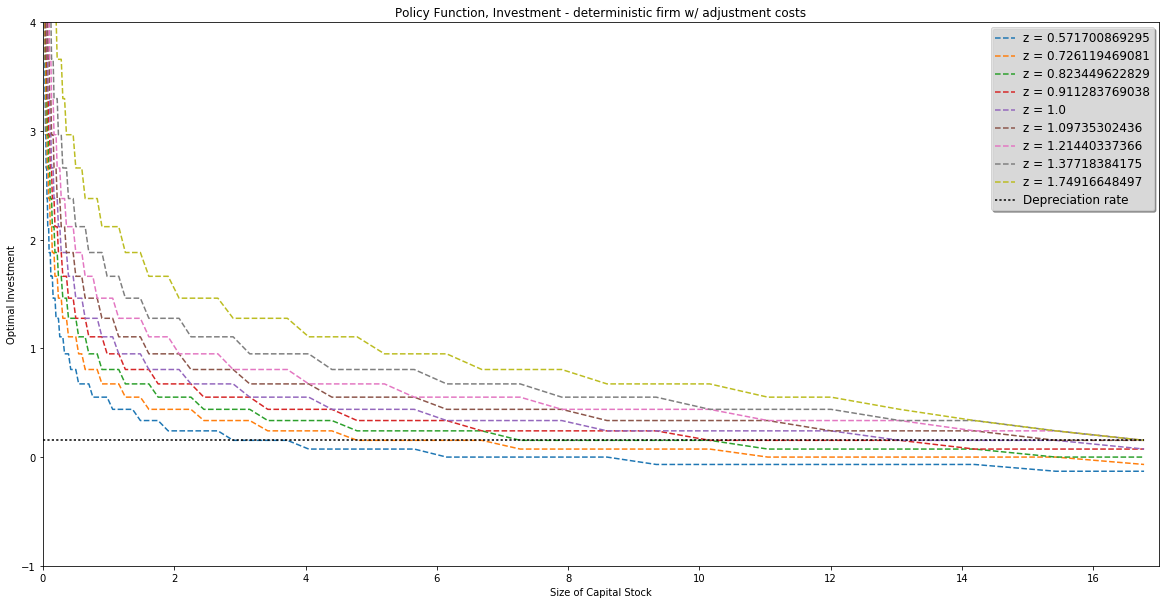

In [137]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(20,10))
for z in range(sizez):
    ax.plot(kvec, (optI[:,z]/kvec), '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.ylim(-1,4)
plt.xlim(0,17)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - deterministic firm w/ adjustment ' +
          'costs')

# Problem 2

This problem is essentially the same as 1, except that we are using a different (fixed) cost of investment.

We can now establish the profit and cash-flow functions as grids, recall:

$$ \pi(z,k)=\left(1-\alpha_{l}\right)\left(\frac{\alpha_{l}}{w}\right)^{\frac{\alpha_{l}}{1-\alpha_{l}}} z^{\frac{1}{1-\alpha_{l}}}k^{\frac{\alpha_{k}}{1-\alpha_{l}}} $$

Per period flows are then:

$$ e(k,k',z) = \pi(k, z) - (k'-(1-\delta)k) - \psi k $$

if $(k'-(1-\delta)k) > 0 $, and 

$$ e(k,(1-\delta)k,z) = \pi(k, z) $$

if the firm decides not to invest.

NOTE that we do NOT need to use two maximizations as the problem statement demands - instead, we observe the following: 

Since we have conveniently choosen the grid, this happens at $index_k - dens$ if we have given dens an integer value.

Thus, we can simply adjust the firm's cash flow function accordingly (it will have 

As remarked by Professor DeBacker in lecture, we will use $\psi = 0.03$.

In [160]:
psi1 = 0.03

# firm cash flow, e
e2 = np.zeros((sizek, sizek, sizez))
for z in range(sizez):
    for i in range(sizek):
        for j in range(sizek):
            if j == i - dens:
                e2[ i, j, z] = op[i,z] 
            else:
                e2[ i, j, z] = op[i,z] - kvec[j] + (1 - delta - psi) * kvec[i] 
                
                

In [161]:
e2.shape

(118, 118, 9)

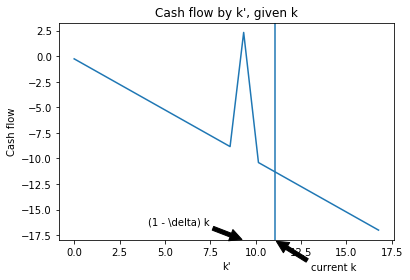

In [185]:
plt.plot(kvec, e2[112,:,4])
plt.axvline(kvec[112])
plt.annotate('current k', xy=(kvec[112], -18), xytext=(kvec[114], -21),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('(1 - \delta) k', xy=(kvec[110], -18), xytext=(kvec[100], -16.5),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
#plt.plot(kvec[110])
plt.xlabel('k\'')
plt.ylabel('Cash flow')
plt.title('Cash flow by k\', given k')
plt.show()

In [150]:
VFtol = 1e-4
#VFdist = 7.0
VFmaxiter = 300
#V = np.zeros((sizek, sizez))  # initial guess at value function
V = np.ones((sizek, sizez))
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
# Vstore = np.zeros((sizek, VFmaxiter, sizez))  # initialize Vstore array
#VFiter = 1
#start_time = time.clock()

In [152]:
VFdist = 7.0
VFiter = 1
start_time = time.clock()
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for h in range(sizez): 
                Vmat[i, j, h] = e2[i, j, h] + betafirm \
                * V[j,:].dot(pi[:,h])
    V = Vmat.max(axis=1)  # apply max operator to Vmat (to get V(k))
    PF = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
        # function for this iteration and value function from past iteration
    VFiter += 1

VFI_time = time.clock() - start_time
if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')
print('VFI took ', VFI_time, ' seconds to solve')




Value function converged after this many iterations: 2
VFI took  0.2883209999999963  seconds to solve


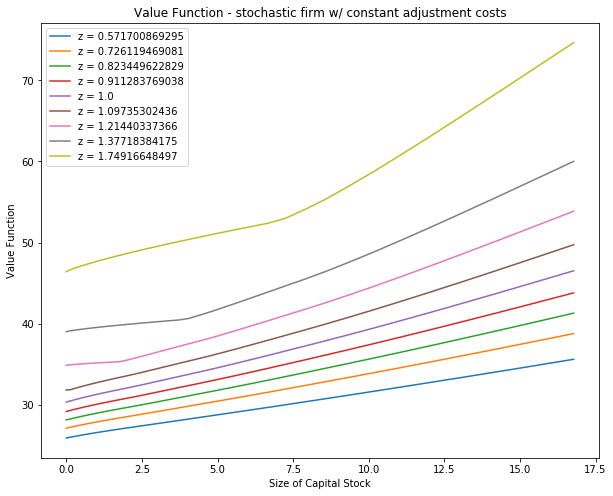

In [157]:
plt.figure(figsize = (10,8))
for z in range(sizez):
    plt.plot(kvec, V[:,z], label ='z = '+str(z_grid[z]))

plt.legend(loc='upper left')
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Function - stochastic firm w/ constant adjustment costs')

### Policy function

In [186]:
optK = kvec[PF]
optI = np.zeros((sizek, sizez))
for i in range(sizez):
    optI[:,i] = optK[:,i] - (1 - delta) * kvec

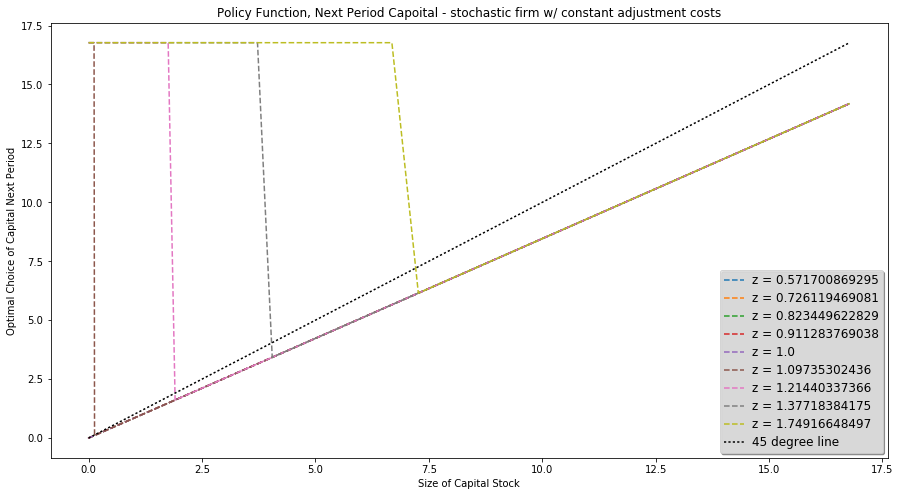

In [188]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,8))
for z in range(sizez):
    ax.plot(kvec, optK[:,z], '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - stochastic firm w/ constant adjustment ' +
          'costs')

### Investment Decision

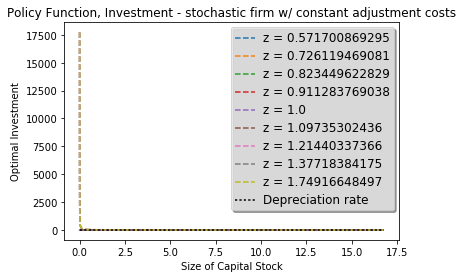

In [189]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots()
for z in range(sizez):
    ax.plot(kvec, (optI[:,z]/kvec), '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - stochastic firm w/ constant adjustment ' +
          'costs')

Once again, clearly not helpful. Zooming in:

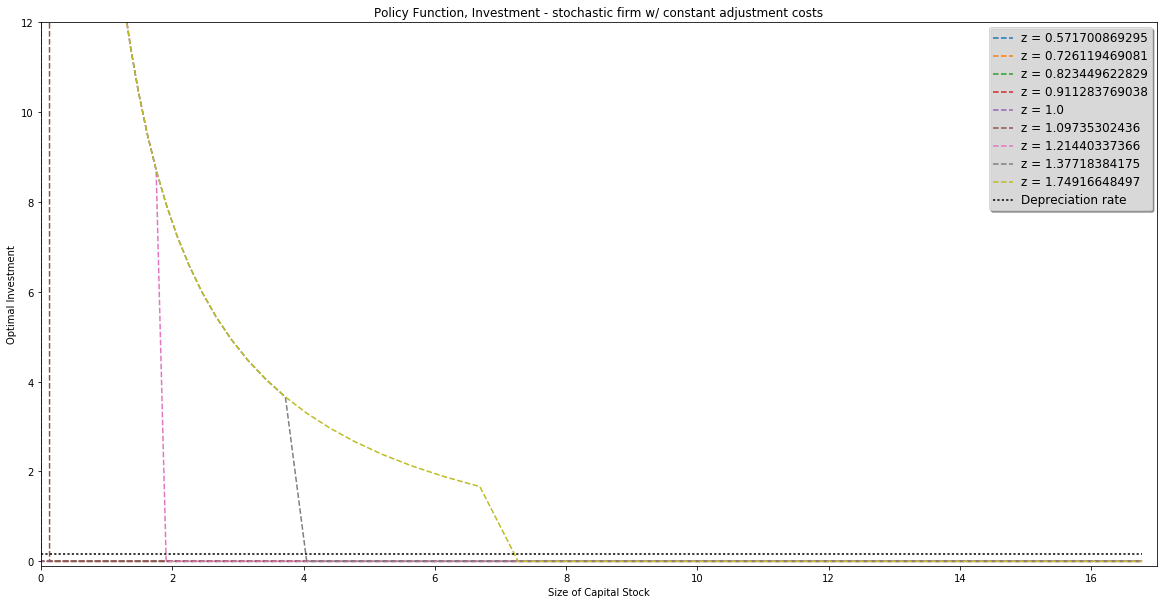

In [193]:
# Plot investment rule as a function of firm size
fig, ax = plt.subplots(figsize=(20,10))
for z in range(sizez):
    ax.plot(kvec, (optI[:,z]/kvec), '--', label='z = '+str(z_grid[z]))
ax.plot(kvec, (np.ones(sizek)*delta), 'k:', label='Depreciation rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.ylim(-0.1,12)
plt.xlim(0,17)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Investment')
plt.title('Policy Function, Investment - stochastic firm w/ constant adjustment ' +
          'costs')

### Analysis

Before the implementation, I expected the value function to have a kink, which would indicate above what level of capital not investing would be wiser than investing marginally (when the max in the problem would be satisfied by both arguments).

This prediction has been confirmed in the implementation.

We can also see by comparison that the investment rule changes approximately at the same points where the policy function crossed the 45 degree line (stationary state). Above that state, the cost to investing makes it more lucrative to just let the capital depreciate down to SS level, instead of smoothing.

# Problem 3

In [211]:
on = np.empty_like(PF)
on.shape
on

array([[           8192,             336,               0, ...,
                      1, 140247827558976,              28],
       [     4524954488,      4294967298,      4524954488, ...,
             4294967297,      4527650608,     21474836481],
       [    21474836505, 140247827559016,      4530538736, ...,
        140247827559112,              28,      4730556576],
       ..., 
       [140247840992608, 140247840992592, 140247840992752, ...,
        140247840992464, 140247840992496, 140247840992512],
       [140247840992272, 140247840992416, 140247840992400, ...,
        140247840992240, 140247840992256, 140247840992288],
       [140247840992304, 140247840992384, 140247840992576, ...,
        140247840992336, 140247840992320, 140247840992064]])

### Optimality conditions

As before, from the notes we have 
$$ \pi(z,k) = (1 - \alpha_l) (\frac{\alpha_l}{w})^{\frac{\alpha_l}{1 - \alpha_l}} z^{\frac{1}{1 - \alpha_l}} k^{\frac{\alpha_k}{1 - \alpha_l}} $$

and the problem defines quadratic adjustment costs:

$$c(k',k) = \frac{\psi}{2}\frac{(k' - (1 - \delta)k)^2}{k} $$

Optimality demands that

$$ p^k + c_1(k',k) = \beta\mathbb{E} [\pi_2(z',k') + (1 - \delta)  - c_2(k'',k')]$$

and assuming $p^k = 1$ as before thus gives:

$$ 1 + c_1(k',k) = \beta\mathbb{E} [\pi_2(z',k') + (1 - \delta)  - c_2(k'',k')]$$


the function we are going to use to find the policy iteration, where 
$$ c_1(k',k) = \frac{\psi(k' - (1 - \delta)k)}{k} $$


$$ c_2(k',k) =  - \frac{\psi}{2}\frac{2(k' - (1 - \delta)k)(1 - \delta )k + (k' - (1 - \delta)k)^2}{k^2} $$

$$ \pi_2(z,k) = \alpha_k (\frac{\alpha_l}{w})^{\frac{\alpha_l}{1 - \alpha_l}} z^{\frac{1}{1 - \alpha_l}} k^{\frac{\alpha_k + \alpha_l - 1}{1 - \alpha_l}} $$


As John Stachurski, I will be using a root finder in the policy iteration, so we might as well define the above as functions.

In [214]:
# root finder
from scipy.optimize import brentq

# redefining psi 
psi = 1.080


def c1(k_new, k):
    return psi * (k_new - (1 - delta)*k)/k
   
def c2(k_new, k):
    return -(psi / 2) * (2*(k_new - (1 - delta)*k)*(1 - delta )*k + (k_new - (1 - delta)*k)**2)/(k**2)

def pi2(k, z):
    return alpha_k *((alpha_l / w)) ** (alpha_l / (1 - alpha_l)) * z ** (1 / (1 - alpha_l)) * \
           k ** ((alpha_k + alpha_l - 1)/(1 - alpha_l))
PFtol = 1e-6
PFdist = 7.0
PFmaxiter = 3000
PFiter = 1
start_time = time.clock()

In [243]:

PF2 = np.ones((sizez,len(kvec)))
k_new2 = np.ones(sizez)
while PFdist > PFtol and PFiter < PFmaxiter:
    PF2_new = np.copy(PF2) 
    for j in range(sizek):  
        for i in range(sizez):          
            def h(k_new):
                for k in range(sizez): 
                    k_new2[k] = np.interp(PF2[i,j], kvec, PF2[k,:])
                expe = (pi2(PF2[i,j], z_grid) + (1 - delta)
                                 - c2(k_new2,PF2[i,j]).dot(pi[:,j])) 
                c1n = c1(k_new,kvec[j])
                return 1 + c1n  - (betafirm * expe)
            
            k_star = brentq(h, 1e-8, 1e-8)
            PF2[i, j] = k_star
            
    PFdist = np.absolute(PF2 - PF2_new).max()
    PFiter += 1
        
PF_time = time.clock() - start_time
    
if PFiter < PFmaxiter:
    print('Policy function converged after this many iterations:', PFiter)
else:
    print('Policy function did not converge')

print('Coleman Policy Iteration took ', PF_time, ' seconds to solve')

Policy function converged after this many iterations: 36
PFI took  54.69932399999993  seconds to solve


We proceed analogously to the value function iteration, with the only difference being the root finder and the focus on the policy function.

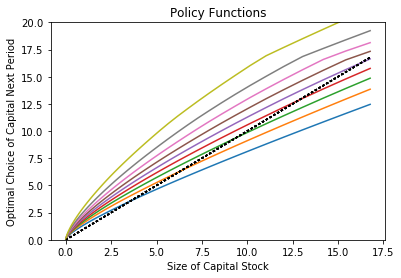

In [222]:
for i in range(9):
    plt.plot(kvec, Kg[i])
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Functions')
    plt.plot(kvec, kvec, 'k:', label='45 degree line')
    plt.ylim((0,20))
plt.show()

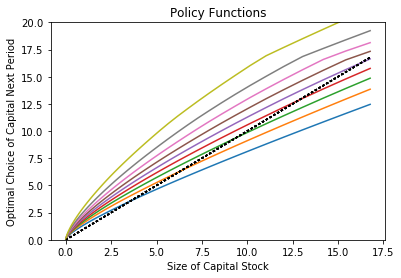

In [244]:
for i in range(sizez):
    plt.plot(kvec, PF2[i])
    plt.xlabel('Size of Capital Stock')
    plt.ylabel('Optimal Choice of Capital Next Period')
    plt.title('Policy Functions')
    plt.plot(kvec, kvec, 'k:', label='45 degree line')
    plt.ylim((0,20))
plt.show()

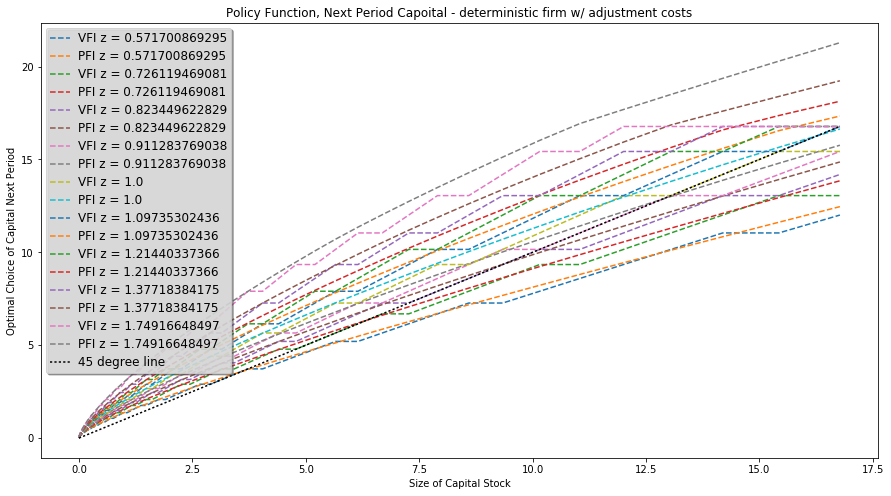

In [257]:




# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,8))
for z in range(sizez):
    ax.plot(kvec, optK1[:,z], '--', label='VFI z = '+str(z_grid[z]))
    ax.plot(kvec, PF2[z], '--', label='PFI z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

Decluttering a little:

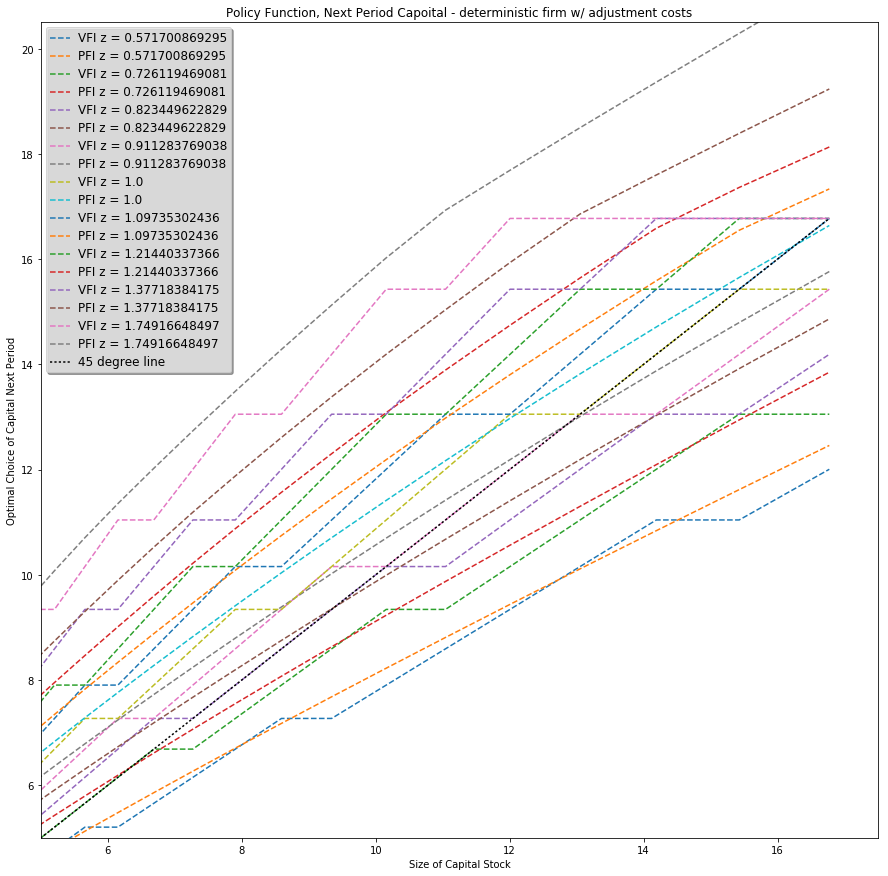

In [261]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,15))
for z in range(sizez):
    ax.plot(kvec, optK1[:,z], '--', label='VFI z = '+str(z_grid[z]))
    ax.plot(kvec, PF2[z], '--', label='PFI z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlim(5, 17.5)
plt.ylim(5, 20.5)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

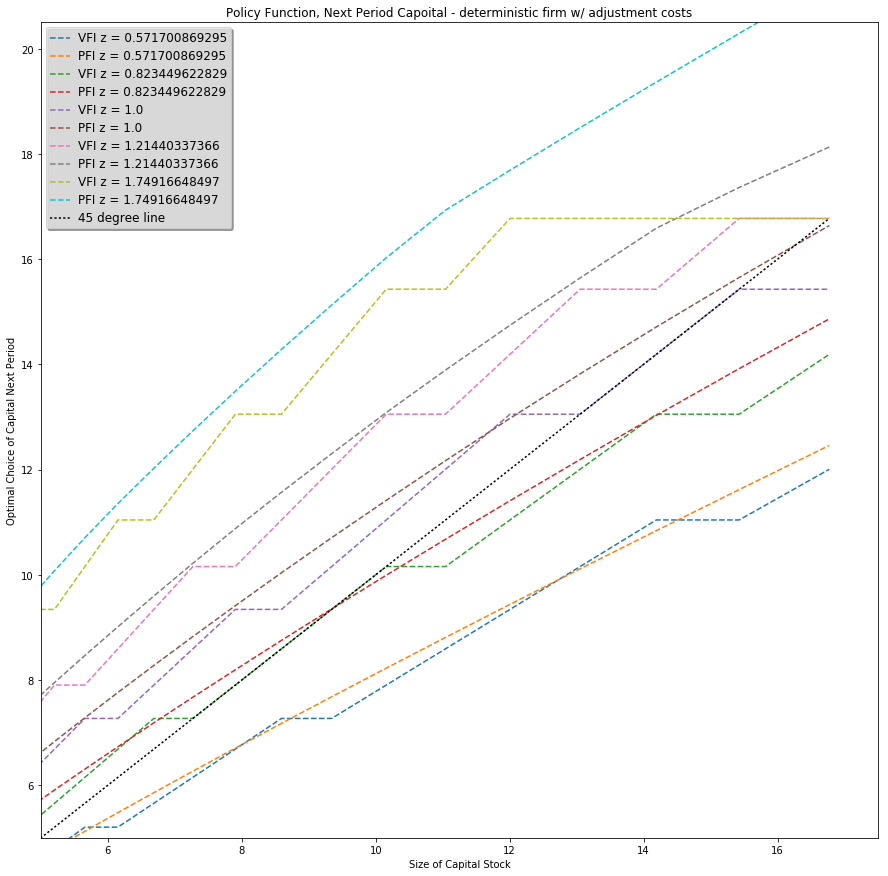

In [265]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,15))
for z in range(sizez):
    if z%2 == 0:
        ax.plot(kvec, optK1[:,z], '--', label='VFI z = '+str(z_grid[z]))
        ax.plot(kvec, PF2[z], '--', label='PFI z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlim(5, 17.5)
plt.ylim(5, 20.5)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

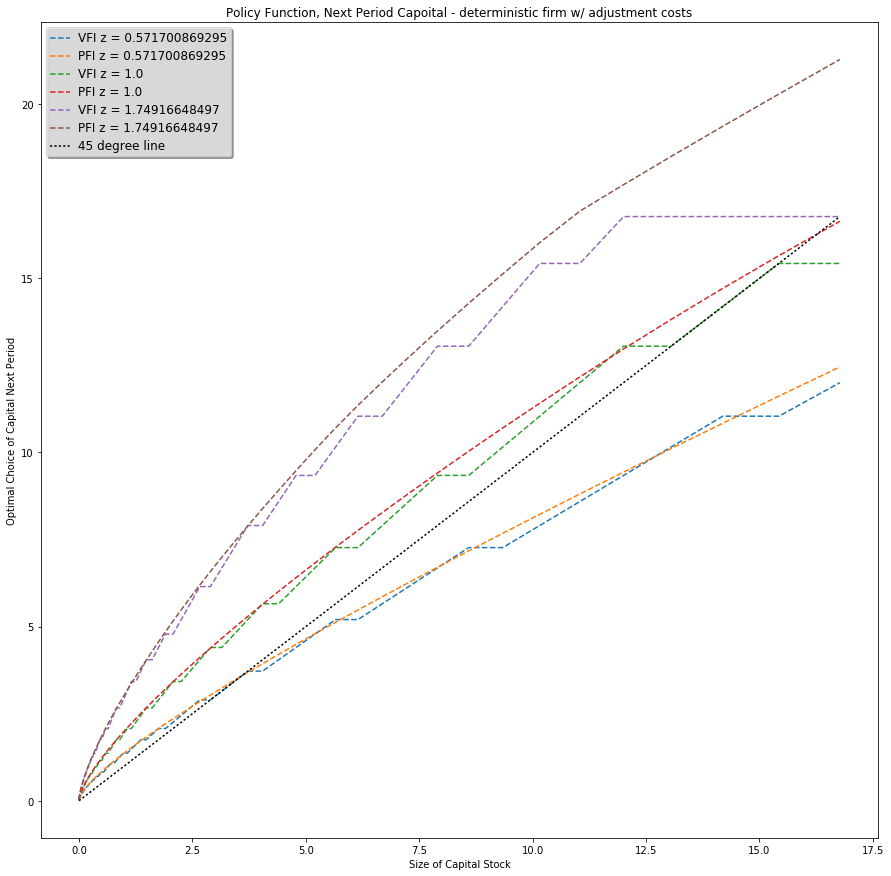

In [267]:
# Plot optimal capital stock rule as a function of firm size
fig, ax = plt.subplots(figsize=(15,15))
for z in [0, 4, 8]:
    ax.plot(kvec, optK1[:,z], '--', label='VFI z = '+str(z_grid[z]))
    ax.plot(kvec, PF2[z], '--', label='PFI z = '+str(z_grid[z]))
ax.plot(kvec, kvec, 'k:', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=True)
# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
#plt.xlim(5, 17.5)
#plt.ylim(5, 20.5)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Optimal Choice of Capital Next Period')
plt.title('Policy Function, Next Period Capoital - deterministic firm w/ ' +
          'adjustment costs')

We can see that they are roughly equivalent, but it shows that the discretization in the former (and particularly the cutoff value for k), has deteriorated the quality of the solution with the procedure in Problem 2.

The root finder is more accurate, and doesn't rely on discretized space. An individual root finding call lasts longer than matrix iteration, but its accuracy allows for convergence in fewer steps, making up for its slowness immmensely (to see this, divide time by iteration number, and total speed, respectively.

# Problem 4

In [196]:
eig_values, eig_vectors = np.linalg.eig(pi)
print('Eigenvalues = ', eig_values)
print('Eigenvectors = ', eig_vectors)

Eigenvalues =  [  1.00000000e+00   7.37013058e-01   4.63326506e-01   2.11848339e-01
   6.39661368e-02   1.19674802e-02   1.29534924e-03   7.27378601e-05
   1.61597748e-06]
Eigenvectors =  [[ -3.33333333e-01  -5.58528104e-01  -5.73839652e-01   4.19001494e-01
    2.40816537e-01  -1.11234979e-01  -4.00155711e-02  -1.05302077e-02
    1.75850946e-03]
 [ -3.33333333e-01  -3.57065981e-01  -5.44513159e-02  -3.43442794e-01
   -5.40295448e-01   4.86567397e-01   3.04404504e-01   1.33428261e-01
   -3.66424499e-02]
 [ -3.33333333e-01  -2.21625876e-01   1.76069700e-01  -3.90557369e-01
   -1.34364540e-01  -3.16174777e-01  -5.48105295e-01  -4.45399172e-01
    1.98532380e-01]
 [ -3.33333333e-01  -1.06921530e-01   2.89840125e-01  -2.32270827e-01
    2.42487476e-01  -3.88474527e-01   5.79269639e-02   5.32640208e-01
   -4.92672185e-01]
 [ -3.33333333e-01  -3.55773203e-16   3.24762286e-01  -1.13887644e-16
    3.82711950e-01   1.98486822e-15   4.51578795e-01   8.76137490e-14
    6.58047492e-01]
 [ -3.333333

In [197]:
# Now we'll put out the eigenvector the corresponds to eigenvalue 1
eig_vec1 = eig_vectors[:,0]

# And compute the stationary distribution this reporsents:
SD_eig = eig_vec1/eig_vec1.sum()
print('Stationary distribution of Pi = ', SD_eig)

Stationary distribution of Pi =  [ 0.11111111  0.11111111  0.11111111  0.11111111  0.11111111  0.11111111
  0.11111111  0.11111111  0.11111111]


This result is actually not too surprising, since we explicity defined the buckets to have equal probability.

In [23]:
sum(on[:,0,0])

144

In [26]:
sum(on[0,:,0])

264

In [18]:
on[0,3,1]

13

In [ ]:
on[0][3,1]

In [ ]:
on[0]

In [ ]:
np.ones((3,12,4))